# 第7章 异方差

1.画残差图

2.BP检验

3.white检验

4.WLS

案例：
回归函数：$$lntc = \beta_0 + \beta_1 lnq + \beta_2 lnpl + \beta_3 lnpk + \beta_4 lnpf + \epsilon$$

In [1]:
# 包+数据

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

data = pd.read_stata('../2_Data/Data-2e/nerlove.dta')
data.head()

,tc,q,pl,pf,pk,lntc,lnq,lnpf,lnpk,lnpl
0,0.082,2,2.1,17.900000,183,-2.501036,0.693147,2.884801,5.209486,0.741937
1,0.661,3,2.1,35.099998,174,-0.414001,1.098612,3.558201,5.159055,0.741937
2,0.990,4,2.1,35.099998,171,-0.010050,1.386294,3.558201,5.141664,0.741937
3,0.315,4,1.8,32.200001,166,-1.155183,1.386294,3.471967,5.111988,0.587787
4,0.197,5,2.1,28.600000,233,-1.624552,1.609438,3.353407,5.451038,0.741937


                            OLS Regression Results                            
Dep. Variable:                   lntc   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     437.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           4.67e-78
Time:                        11:37:37   Log-Likelihood:                -67.509
No. Observations:                 145   AIC:                             145.0
Df Residuals:                     140   BIC:                             159.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5665      1.779     -2.004      0.0

<Axes: xlabel='fitted', ylabel='resid'>

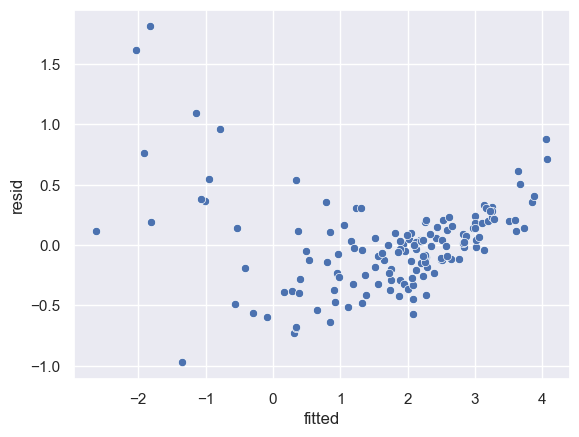

In [19]:
# 锁定数据
nerlove = data

# OLS
X = nerlove[['lnq','lnpl','lnpk','lnpf']]
y = nerlove['lntc']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# 形成拟合值和残差的散点图？
# Y轴是残差，x轴是拟合值
nerlove['resid'] = results.resid
nerlove['fitted'] = results.fittedvalues
nerlove.head()
sns.set_theme(style='darkgrid')
sns.scatterplot(x='fitted',y='resid',data=nerlove)

当拟合值越小时，残差的波动较大，而随着拟合值增加，方差越来越小。

<Axes: xlabel='lnq', ylabel='resid'>

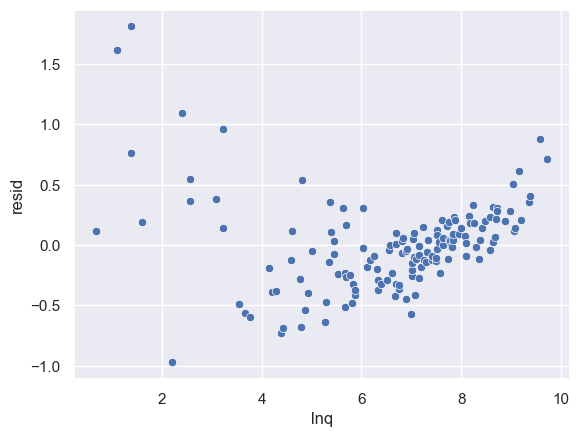

In [12]:
# 残差与解释变量lnq之间的比较
sns.scatterplot(x='lnq',y='resid',data=nerlove)

In [39]:
# BP检验
from statsmodels.stats.diagnostic import het_breuschpagan

# 与解释变量进行BP检验
result_bptest = het_breuschpagan(resid=results.resid,exog_het=X)
print('LM:{}'.format(result_bptest[0]))
print('LM_pvalue:{}'.format(result_bptest[1]))
print('F:{}'.format(result_bptest[2]))
print('F_pvalue:{}'.format(result_bptest[3]))

LM:36.16346038427023
LM_pvalue:2.678071113607596e-07
F:11.62956042077736
F_pvalue:3.5047777290566926e-08


对所有解释变量进行BP检验的结果是拒绝原假设，那么就是存在异方差的。

与拟合值进行BP检验，对某个变量进行BP检验，这么操作的意义何在？


In [40]:
# white检验
from statsmodels.stats.diagnostic import het_white

result_white = het_white(resid=results.resid,exog=X)
result_white

(73.8770971532988,
 3.8000624583372287e-10,
 9.645298335222645,
 2.136169236136455e-14)

## FWLS的计算
### 估计$\sigma_i^2$
1. 先对辅助回归进行拟合，假设lne2是lnq的线性函数 <-- 这个很重要
- X $lnq$
- y :$ln(e^2)$
2. 得到y的预测值，用预测值算权重 $1/\hat\sigma_i^2$

In [55]:
# WLS
## 第一步：计算异方差因子
from math import log, exp

## 这里的核心问题是如何设置条件方差函数
X = nerlove[['lnq']]
y_lne2 = results.resid.apply(lambda x: log(float(x)**2))
# X = sm.add_constant(X) # 无常数项，拟合优度更高
model_lne2 = sm.OLS(y_lne2,X)
results_lne2 = model_lne2.fit()
print(results_lne2.summary())
aw = results_lne2.fittedvalues.apply(lambda x: exp(x))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.745
Model:                            OLS   Adj. R-squared (uncentered):              0.743
Method:                 Least Squares   F-statistic:                              419.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):                    1.58e-44
Time:                        14:50:19   Log-Likelihood:                         -320.74
No. Observations:                 145   AIC:                                      643.5
Df Residuals:                     144   BIC:                                      646.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [56]:
## 第二步：代入模型，WLS进行回归
X = nerlove[['lnq','lnpl','lnpk','lnpf']]
y = y = nerlove['lntc']
X = sm.add_constant(X)
model_fwls = sm.WLS(y,X,weights=1/aw)
results_fwls = model_fwls.fit()
print(results_fwls.summary())

                            WLS Regression Results                            
Dep. Variable:                   lntc   R-squared:                       0.962
Model:                            WLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     895.0
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.33e-98
Time:                        14:51:40   Log-Likelihood:                -13.193
No. Observations:                 145   AIC:                             36.39
Df Residuals:                     140   BIC:                             51.27
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5221      0.993     -5.562      0.0